In [40]:
# dla wszystkich testowych

In [1]:
from dn3.configuratron import ExperimentConfig
from dn3.data.dataset import Thinker
from dn3.trainable.processes import StandardClassification
from result_tracking import ThinkerwiseResultTracker

from dn3.transforms.instance import To1020

from dn3_ext import BENDRClassification, LinearHeadBENDR

import utils
import numpy as np
import matplotlib.pyplot as plt

/dmj/fizmed/jjakubowska/.pyenv/versions/3.6.10/envs/trening/lib/python3.6/site-packages/llvmlite/binding/ffi.py:175: UserWarning: Module dn3 was already imported from /dmj/fizmed/jjakubowska/.pyenv/versions/3.6.10/envs/trening/lib/python3.6/site-packages/dn3/__init__.py, but /dmj/fizmed/jjakubowska/BENDR is being added to sys.path
  from pkg_resources import resource_filename


In [2]:
predictions_path = 'predictions/'
experiment_model = 'linear-sleepedf-AASM-pool1-all_data.pt'

In [4]:
experiment = ExperimentConfig("configs/testing.yml")

ds_name = 'sleep-edf'
ds_config = experiment.datasets[ds_name]
database_path = experiment.datasets['sleep-edf'].toplevel
experiment.encoder_weights = '/dmj/fizmed/jjakubowska/BENDR/weights/' + experiment_model 

dataset = ds_config.auto_construct_dataset()

dataset.add_transform(To1020())
print(dataset.thinkers)

Adding additional configuration entries: dict_keys(['extensions'])
Configuratron found 1 datasets.


Scanning /dmj/fizmed/jjakubowska/physionet.org/files/sleep-edfx/1.0.0/sleep-telemetry/all_data_test. If there are a lot of files, this may take a while...: 100%|██████████| 1/1 [00:00<00:00, 270.83it/s, extension=.edf]


Creating dataset of 4 Preloaded Epoched recordings from 2 people.


Loading Sleep EDFx Cassette: 100%|██████████| 2/2 [00:03<00:00,  1.52s/person]

>> Sleep EDFx Cassette | DSID: None | 2 people | 3675 trials | 90 channels | 3000 samples/trial | 100.0Hz | 0 transforms
Constructed 1 channel maps
Used by 4 recordings:
EEG (original(new)): FP1(FP1) PZ(PZ) 
EOG (original(new)): HEOGL(VEOGL,VEOGR,HEOGL,HEOGR) 
REF (original(new)): 
EXTRA (original(new)): 
Heuristically Assigned: HEOGL(VEOGL,VEOGR,HEOGL,HEOGR) 
--------------------
Excluded ['EMG submental', 'Marker']
OrderedDict([('13', <dn3.data.dataset.Thinker object at 0x7f0bb447d978>), ('24', <dn3.data.dataset.Thinker object at 0x7f0acf644b00>)])


In [5]:
# dataset.thinkers.pop('18')
# dataset.thinkers
# print(experiment.encoder_weights)

In [6]:
model_type = 'linear'

if model_type == utils.MODEL_CHOICES[0]:
    model = BENDRClassification.from_dataset(dataset, multi_gpu='store_true')
else:
    model = LinearHeadBENDR.from_dataset(dataset)

model.load(experiment.encoder_weights, include_classifier=True)

model = model.train(False)
# model

Creating LinearHeadBENDR using: 20 channels x 3000 samples at 100.0Hz | 5 targets
Receptive field: 143 samples | Downsampled by 96 | Overlap of 47 samples | 31 encoded samples/trial | 1 pooled


In [7]:
# kolejny hook, tym razem przed samym klasyfikatorem 
# wszczepiamy hook w enkoder
features_blobs_latent = []

def hook_feature(module, input, output):
    features_blobs_latent.append(output.cpu().data.numpy())

model._modules.get('extended_classifier').register_forward_hook(hook_feature)

In [8]:
# predictions from model for s02

process = StandardClassification(model) 

inputs, outputs = process.predict(dataset)
y_pred = outputs.softmax(dim=1)
y_numpy = y_pred.numpy()

# get tags with highest probability
tags_BENDR = np.argmax(y_numpy, axis=1)
true_tags = inputs[1].numpy()

print(len(tags_BENDR), len(true_tags))

GPU(s) detected: training and model execution will be performed on GPU.


Predicting: 100%|██████████| 3675/3675 [00:16<00:00, 224.86it/s]


3675 3675


In [9]:
features = np.zeros((len(features_blobs_latent), 512))

for i in range(len(features_blobs_latent)):
    features[i, :] = features_blobs_latent[i][0]

In [10]:
features.shape

(3675, 512)

In [11]:
# tsne
# t-SNE https://distill.pub/2016/misread-tsne/

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=100, learning_rate=1000)
tsne_results = tsne.fit_transform(features)


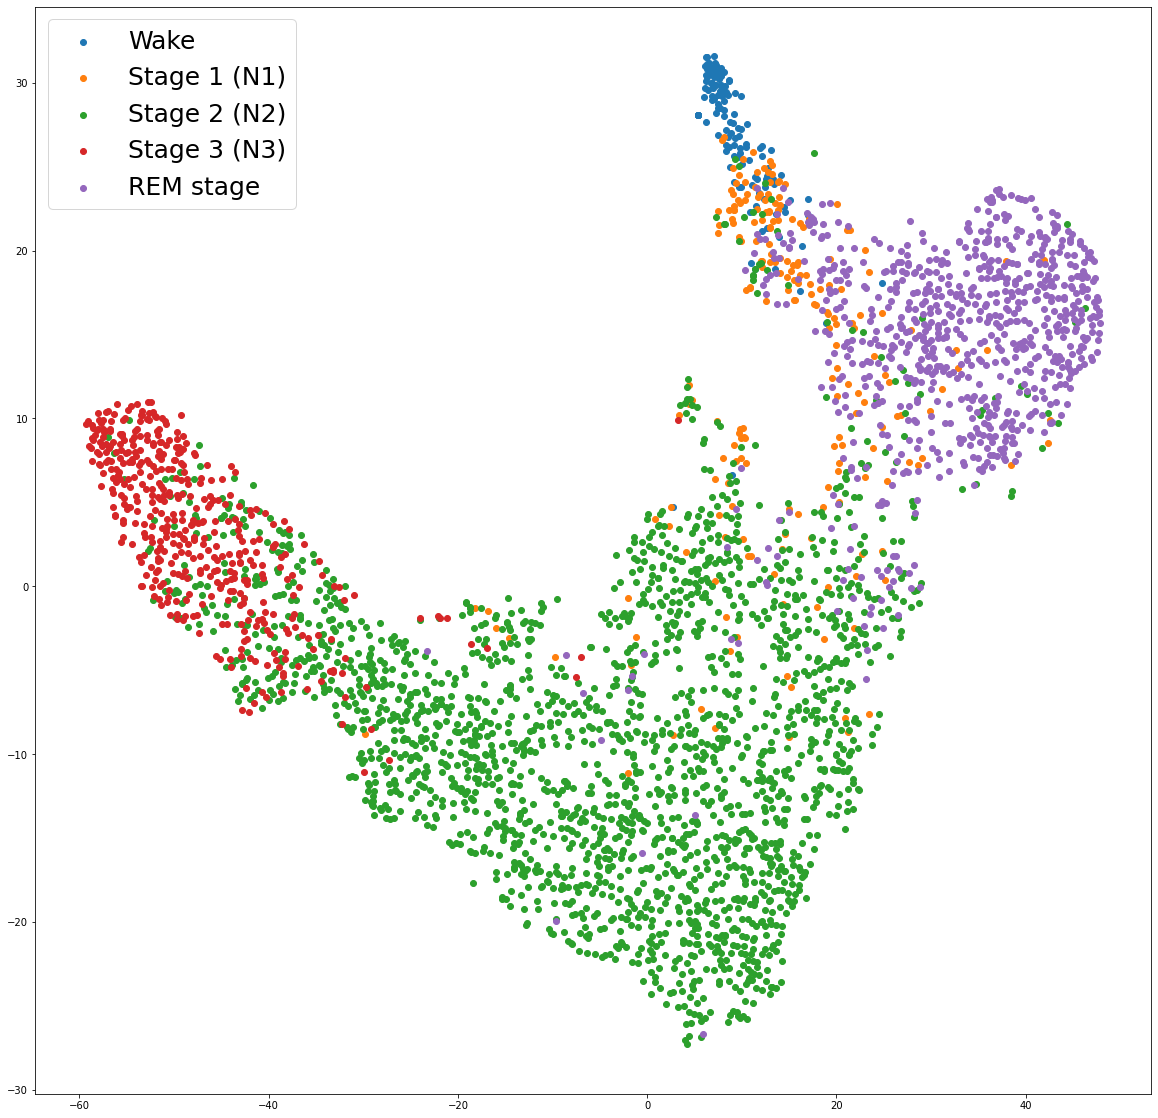

In [12]:
fig = plt.figure(figsize=(20,20))
labels = ['Wake', 'Stage 1 (N1)', 'Stage 2 (N2)', 'Stage 3 (N3)', 'REM stage']        
classes = [0,1,2,3,4]

for clas in np.unique(true_tags):
    plt.scatter(*tsne_results[true_tags==clas].T, cmap='jet', label=labels[clas]) #, c=true_tags[true_tags==clas]
# ax[1].scatter(*tsne_results.T, cmap='jet') #c=y_train, 
plt.legend(prop = { "size": 25 }, fontsize="20")
plt.show()

In [13]:

# umap

import umap as umap

from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP(n_neighbors=40, n_components=2) #, n_neighbors=40, min_dist=0)
embedding = reducer.fit_transform(features)
embedding.shape

(3675, 2)

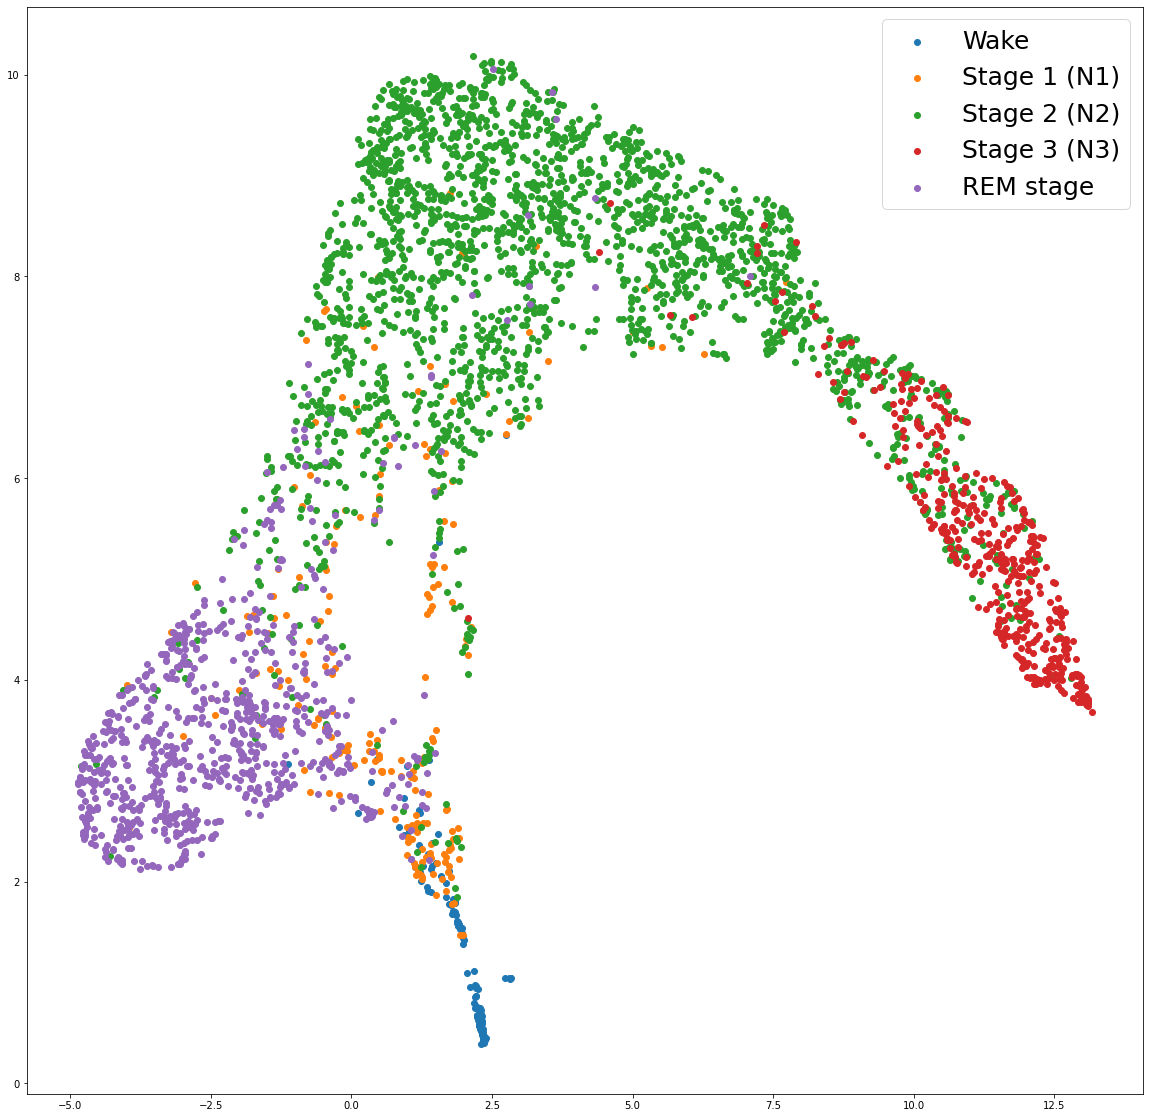

In [15]:
fig = plt.figure(figsize=(20,20))
# labels = ['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R']        

for clas in np.unique(true_tags):
    plt.scatter(embedding[:,0][true_tags==clas], embedding[:,1][true_tags==clas], cmap='jet', label=labels[clas]) #, c=true_tags[true_tags==clas]
# ax[1].scatter(*tsne_results.T, cmap='jet') #c=y_train, 
plt.legend(prop = { "size": 25 }, fontsize="20")
plt.show()